# Tasca 6A: Visualització gràfica de Múltiples variables

Roger Gallart - 8 maig 2021

## Nivell 1

### Exercici 1

Realitza la pràctica del notebook a GitHub "03 EXAMINING DATA" amb seaborn i el dataset "tips".

https://github.com/itacademy-rogergallart/visualitzacio_grafica_de_multiples_variables/blob/main/03_EXAMINING_DATA.ipynb


## Nivell 2

### Exercici 2

Repeteix l'exercici 1 amb el dataset que disposem en el repositori de GitHub PRE-PROCESSING-DATA, movies.dat



In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [115]:
## Llegim el fitxer
movies = pd.read_csv("https://raw.githubusercontent.com/IT-Academy-BCN/Data-Science/main/Pre-processing-data/movies.dat",
                 sep='::',  encoding = 'ISO-8859-1', index_col=0, names=['TitleYear','Genres'], engine='python')

In [116]:
movies.head()

,TitleYear,Genres
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


In [117]:
# Separem el Títol i l'Any usant RegEx
foo = movies.TitleYear.str.extract(r'(.+)\s*\((\d\d\d\d)\)$')
movies['Title'] = foo.iloc[:,0]
movies['Year'] = foo.iloc[:,1]

movies['Title'] = movies['Title'].str.strip() # Elimina espais al principi i final d'un string, si n'hi ha
movies['Year'] = movies['Year'].astype('int64') # Convertim l'any a int64

In [118]:
# Esborrem la columna TitleYear i reordenem la resta de columnes
del movies['TitleYear']
movies = movies[['Title','Year','Genres']]

# Eliminem el "'s" del gènere "Children's" per evitar problemes posteriorment
movies['Genres'] = movies['Genres'].str.replace("Children's", "Children")

movies.head()

,Title,Year,Genres
1,Toy Story,1995,Animation|Children|Comedy
2,Jumanji,1995,Adventure|Children|Fantasy
3,Grumpier Old Men,1995,Comedy|Romance
4,Waiting to Exhale,1995,Comedy|Drama
5,Father of the Bride Part II,1995,Comedy


In [119]:
# Generem un dataframe amb columnes per cada gènere en format OneHotEncoding 
# i les afegim al DataFrame original
genres = movies.Genres.str.get_dummies(sep='|').add_prefix('Genre_')
movies = pd.concat([movies,genres], axis=1)

# Eliminem la columna de Gènere original
del movies['Genres']

In [120]:
movies.head()

,Title,Year,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Children,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,Genre_Fantasy,Genre_Film-Noir,Genre_Horror,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller,Genre_War,Genre_Western
1,Toy Story,1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Jumanji,1995,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Waiting to Exhale,1995,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Crearem com a **variable categòrica 'Decade'** que correspondrà a la dècada a la que pertany una pel·lícula (1920s, 1930s, etc)

In [121]:
# Funció per calcular la dècada (str) a la que pertany un any (int)
def calc_decade(year):
  ''' 
  Funció per calcular la dècada a partir de l'any, e.g:
  1923 --> 1920s
  2003 --> 2000s

  Paràmetres:
    year:int
  Retorna:
    decade:str
  '''
  return str(int(np.floor(year / 10) * 10))+'s'

# Testejem la funció amb alguns valors
calc_decade(1923), calc_decade(1956), calc_decade(2000)

('1920s', '1950s', '2000s')

In [122]:
# Creem un tipus categòric ordenat per codificar les dècades
decade_dtype = pd.api.types.CategoricalDtype(
    categories=[str(x)+'s' for x in range(1910,2010,10)], ordered=True)

decade_dtype

CategoricalDtype(categories=['1910s', '1920s', '1930s', '1940s', '1950s', '1960s',
                  '1970s', '1980s', '1990s', '2000s'],
                 ordered=True)

A partir d'aquestes dades creem 4 DataFrames que utilitzarem per fer l'exercici:

- **'movies'**: que conté el llistat de totes les pel·lícules, amb el títol, any, dècada i gèneres
- **'moviesByYear'**: que permetrà analitzar el nombre de pel·lícules (total i per gènere) estrenades cada any
- **'moviesByYearGenre'**: idem a l'anterior però amb el gènere com a variable categòria indicant quantitat (absolut i percentatge) de películes anuals de cada gènere
- **'moviesByPublic'**: que conté permetrà analitzar quantes de les películes estrenades cada any per al públic infantil (o general) i per al públic no-infantil (adult) són d'animació o d'actors reals.

In [123]:
# DataFrame: movies

# Afegim la variable categòrica 'Decade' i reordenem les columnes

movies['Decade'] = movies['Year'].apply(calc_decade)
movies['Decade'] = movies['Decade'].astype(decade_dtype)
movies = movies[['Title', 'Year', 'Decade','Genre_Action', 'Genre_Adventure', 'Genre_Animation',
       'Genre_Children', 'Genre_Comedy', 'Genre_Crime', 'Genre_Documentary',
       'Genre_Drama', 'Genre_Fantasy', 'Genre_Film-Noir', 'Genre_Horror',
       'Genre_Musical', 'Genre_Mystery', 'Genre_Romance', 'Genre_Sci-Fi',
       'Genre_Thriller', 'Genre_War', 'Genre_Western']]

movies.sample(5)

,Title,Year,Decade,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Children,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,Genre_Fantasy,Genre_Film-Noir,Genre_Horror,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller,Genre_War,Genre_Western
3090,Matewan,1987,1980s,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1807,"Cool Dry Place, A",1998,1990s,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
413,Airheads,1994,1990s,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2969,"Man and a Woman, A (Un Homme et une Femme)",1966,1960s,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2168,Dance with Me,1998,1990s,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [124]:
# DataFrame: moviesByYear
# Agrupem les pelicules usant "count" per als Titols, "sum" per als Gèneres i
# 'first' per a la Dècada
# Obtenim un dataframe que ens indica el nombre total de pelicules cada any
# i el nombre de pelicules de cada gènere
# IMPORTANT: hi ha pelicules amb diversos gèneres, per això la suma de tots els
# gèneres de un any no és igual al total de pel·lícules d'aquell any

# Diccionari per fer l'agrupació
agg_dict = {x:'sum' for x in movies.columns[3:].to_list()}
agg_dict['Title'] = 'count'
agg_dict['Decade'] = 'first'

moviesByYear = movies.groupby('Year').agg(agg_dict)
moviesByYear.reset_index(inplace=True)

# Corregim els títols
moviesByYear.rename(columns={'Title':'Total'}, inplace=True)

# Tornem a convertir Decade en categòrica
moviesByYear['Decade'] = moviesByYear['Decade'].astype(decade_dtype)

# Reordenem les columnes
moviesByYear = moviesByYear[['Year', 'Decade' , 'Total','Genre_Adventure', 'Genre_Animation', 'Genre_Children',
       'Genre_Comedy', 'Genre_Crime', 'Genre_Documentary', 'Genre_Drama',
       'Genre_Fantasy', 'Genre_Film-Noir', 'Genre_Horror', 'Genre_Musical',
       'Genre_Mystery', 'Genre_Romance', 'Genre_Sci-Fi', 'Genre_Thriller',
       'Genre_War', 'Genre_Western']]

moviesByYear.sample(5)

,Year,Decade,Total,Genre_Adventure,Genre_Animation,Genre_Children,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,Genre_Fantasy,Genre_Film-Noir,Genre_Horror,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller,Genre_War,Genre_Western
79,1999,1990s,283,7,7,11,103,12,15,130,2,0,14,1,5,37,15,40,4,1
42,1962,1960s,20,4,0,2,0,0,0,8,0,2,3,1,0,0,2,4,2,1
36,1956,1950s,19,2,0,0,1,1,0,6,0,2,2,1,0,0,7,3,1,1
0,1919,1910s,3,1,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0
9,1929,1920s,3,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0


In [125]:
# DataFrame: moviesByYearGenre

moviesByYearGenre = moviesByYear.melt(id_vars=['Year','Decade','Total'],var_name='Genre', value_name='Quantity')

# Eliminem el prefix "Genre_" dels gèneres i convertim a categòrica
moviesByYearGenre['Genre'] = moviesByYearGenre['Genre'].str.replace(r'^Genre_',r'')
moviesByYearGenre.sort_values(by=['Year','Genre'],inplace=True, ignore_index=True)

# Convertim Decade i Genre en categòrica
moviesByYearGenre['Decade'] = moviesByYearGenre['Decade'].astype(decade_dtype)
moviesByYearGenre['Genre'] = moviesByYearGenre['Genre'].astype('category')

# Calculem el percentatge de películes de cada gènere estrenades cada any
moviesByYearGenre['Percentage'] = moviesByYearGenre.Quantity*100/moviesByYearGenre.Total
moviesByYearGenre.drop('Total', axis=1, inplace=True)
moviesByYearGenre.head(10)

,Year,Decade,Genre,Quantity,Percentage
0,1919,1910s,Adventure,1,33.333333
1,1919,1910s,Animation,0,0.000000
2,1919,1910s,Children,0,0.000000
3,1919,1910s,Comedy,1,33.333333
4,1919,1910s,Crime,0,0.000000
5,1919,1910s,Documentary,0,0.000000
6,1919,1910s,Drama,2,66.666667
7,1919,1910s,Fantasy,0,0.000000
8,1919,1910s,Film-Noir,0,0.000000
9,1919,1910s,Horror,0,0.000000


In [126]:
# DataFrame: moviesByPublic
# Permetrà analitzar l'evolució del percentatge de pel·lícules d'animació per a nens

moviesByPublic=movies.groupby(['Year','Genre_Children']).agg(
    {'Decade': 'first',
     'Title': 'count',
     'Genre_Animation': 'sum'}
)

moviesByPublic.reset_index(inplace=True)
moviesByPublic.rename(columns={'Title':'Total',
                  'Genre_Children':'Public',
                  'Genre_Animation':'AnimationQty'},
         inplace=True)

moviesByPublic['Public'] = moviesByPublic['Public'].map({0:'Adults', 1:'Children'})
moviesByPublic['NoAnimationQty'] = moviesByPublic['Total']-moviesByPublic['AnimationQty']

# Per cada públic, calculem porcentatge de pelis que van ser animades o no.
moviesByPublic['AnimationPct'] = 100*moviesByPublic['AnimationQty']/moviesByPublic['Total']
moviesByPublic['NoAnimationPct'] = 100*moviesByPublic['NoAnimationQty']/moviesByPublic['Total']

# Convertim Decade i Public en categòrica
moviesByPublic['Decade'] = moviesByPublic['Decade'].astype(decade_dtype)
moviesByPublic['Public'] = moviesByPublic['Public'].astype('category')


In [127]:
# Verifiació: busquem pel·lícules per nens del 1989 i mirem quantes són d'animació i quantes no
moviesByPublic[(moviesByPublic.Year==1989) & (moviesByPublic.Public=='Children')]

,Year,Public,Decade,Total,AnimationQty,NoAnimationQty,AnimationPct,NoAnimationPct
115,1989,Children,1980s,5,2,3,40.0,60.0


In [128]:
# Veiem que al 1989 es van estrenar 5 pel·lícules infantils, 2 d'animació i 3 de no-animació
# Verifiquem si concorda amb el que posa al dataframe original
movies[(movies.Year==1989) & (movies.Genre_Children==1)]

,Title,Year,Decade,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Children,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,Genre_Fantasy,Genre_Film-Noir,Genre_Horror,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller,Genre_War,Genre_Western
2039,Cheetah,1989,1980s,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2054,"Honey, I Shrunk the Kids",1989,1980s,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2081,"Little Mermaid, The",1989,1980s,0,0,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0
2123,All Dogs Go to Heaven,1989,1980s,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2400,Prancer,1989,1980s,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0




---


Repetim la pràctica de l'exercici 1, utilitzant els dataframes creats per les películes

In [129]:
movies.shape

(3883, 21)

In [130]:
movies.ndim

2

In [131]:
movies.columns

Index(['Title', 'Year', 'Decade', 'Genre_Action', 'Genre_Adventure',
       'Genre_Animation', 'Genre_Children', 'Genre_Comedy', 'Genre_Crime',
       'Genre_Documentary', 'Genre_Drama', 'Genre_Fantasy', 'Genre_Film-Noir',
       'Genre_Horror', 'Genre_Musical', 'Genre_Mystery', 'Genre_Romance',
       'Genre_Sci-Fi', 'Genre_Thriller', 'Genre_War', 'Genre_Western'],
      dtype='object')

In [132]:
movies.dtypes

Title                  object
Year                    int64
Decade               category
Genre_Action            int64
Genre_Adventure         int64
Genre_Animation         int64
Genre_Children          int64
Genre_Comedy            int64
Genre_Crime             int64
Genre_Documentary       int64
Genre_Drama             int64
Genre_Fantasy           int64
Genre_Film-Noir         int64
Genre_Horror            int64
Genre_Musical           int64
Genre_Mystery           int64
Genre_Romance           int64
Genre_Sci-Fi            int64
Genre_Thriller          int64
Genre_War               int64
Genre_Western           int64
dtype: object

In [133]:
moviesByYearGenre.Percentage.describe()

count    1377.000000
mean        8.723846
std        12.271304
min         0.000000
25%         0.000000
50%         4.545455
75%        13.043478
max       100.000000
Name: Percentage, dtype: float64

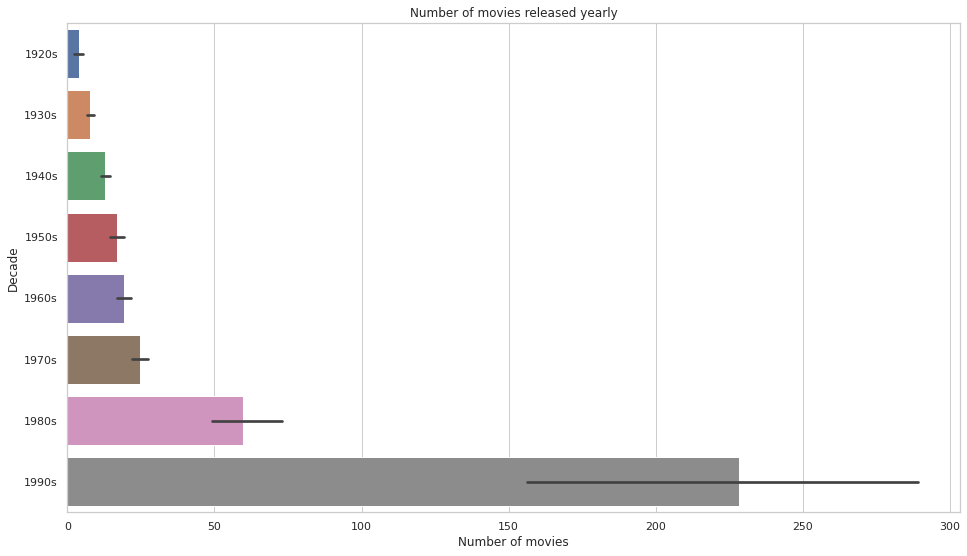

In [134]:
# Exercici:
# sns.barplot(x='tip_pct', y='day', data=tips, orient="h")
# plt.show()

plt.figure(figsize=(16,9))

# Eliminem les dècades de 1910s i 2000s perquè només contenen 1 any (1919 i 2000)
# i falsejarien el gràfic
filter = (moviesByYear.Decade >= '1920s') & (moviesByYear.Decade <= '1990s')

foo = moviesByYear[filter].copy()
foo['Decade'] = foo['Decade'].cat.remove_unused_categories() # Bug de seaborn, per evitar que pinti categories no utilizades les eliminem


sns.barplot(x='Total', y='Decade', data=foo, orient="h")

plt.title('Number of movies released yearly')
plt.xlabel('Number of movies')
plt.ylabel('Decade')
plt.show()

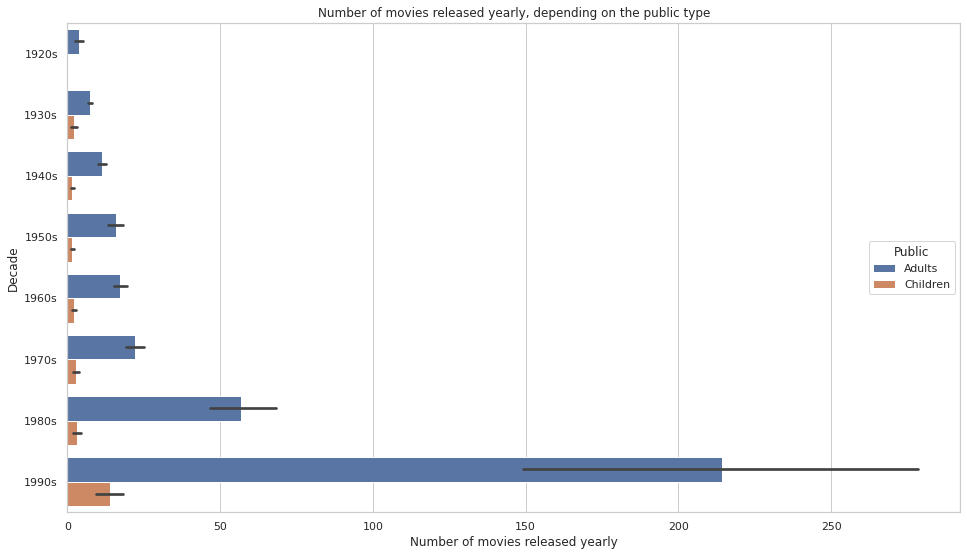

In [135]:
# Exercici:
# sns.barplot(x='tip_pct', y='day', hue='time', data=tips, orient='h')
# plt.show()
# sns.set(style="darkgrid")

plt.figure(figsize=(16,9))

filter = (moviesByPublic.Decade >= '1920s') & \
         (moviesByPublic.Decade <= '1990s')

foo = moviesByPublic[filter].copy()
foo['Decade'] = foo['Decade'].cat.remove_unused_categories() # Bug de seaborn, per evitar que pinti categories no utilizades les eliminem


sns.barplot(x='Total', y='Decade', hue='Public', data=foo, orient='h')
plt.title('Number of movies released yearly, depending on the public type')
plt.xlabel('Number of movies released yearly')
plt.ylabel('Decade')
sns.set(style="darkgrid")

plt.show()


In [136]:
moviesByPublic.describe()

,Year,Total,AnimationQty,NoAnimationQty,AnimationPct,NoAnimationPct
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,1964.152174,28.137681,0.760870,27.376812,17.290672,82.709328
std,22.237242,62.205005,1.359231,62.028743,31.960886,31.960886
min,1919.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1946.250000,3.000000,0.000000,2.000000,0.000000,75.000000
50%,1965.000000,8.500000,0.000000,8.000000,0.000000,100.000000
75%,1983.000000,20.000000,1.000000,19.000000,25.000000,100.000000
max,2000.000000,325.000000,7.000000,323.000000,100.000000,100.000000


In [137]:
moviesByPublic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Year            138 non-null    int64   
 1   Public          138 non-null    category
 2   Decade          138 non-null    category
 3   Total           138 non-null    int64   
 4   AnimationQty    138 non-null    int64   
 5   NoAnimationQty  138 non-null    int64   
 6   AnimationPct    138 non-null    float64 
 7   NoAnimationPct  138 non-null    float64 
dtypes: category(2), float64(2), int64(4)
memory usage: 7.3 KB


In [138]:
round(moviesByPublic.describe(include='all'), 3)

,Year,Public,Decade,Total,AnimationQty,NoAnimationQty,AnimationPct,NoAnimationPct
count,138.000,138,138,138.000,138.000,138.000,138.000,138.000
unique,NaN,2,10,NaN,NaN,NaN,NaN,NaN
top,NaN,Adults,1990s,NaN,NaN,NaN,NaN,NaN
freq,NaN,81,20,NaN,NaN,NaN,NaN,NaN
mean,1964.152,NaN,NaN,28.138,0.761,27.377,17.291,82.709
std,22.237,NaN,NaN,62.205,1.359,62.029,31.961,31.961
min,1919.000,NaN,NaN,1.000,0.000,0.000,0.000,0.000
25%,1946.250,NaN,NaN,3.000,0.000,2.000,0.000,75.000
50%,1965.000,NaN,NaN,8.500,0.000,8.000,0.000,100.000
75%,1983.000,NaN,NaN,20.000,1.000,19.000,25.000,100.000


In [139]:
moviesByPublic.isnull().sum()/len(moviesByPublic)


Year              0.0
Public            0.0
Decade            0.0
Total             0.0
AnimationQty      0.0
NoAnimationQty    0.0
AnimationPct      0.0
NoAnimationPct    0.0
dtype: float64

In [140]:
round((moviesByPublic['Total']).describe(), 3)


count    138.000
mean      28.138
std       62.205
min        1.000
25%        3.000
50%        8.500
75%       20.000
max      325.000
Name: Total, dtype: float64

In [141]:
round((moviesByPublic['Total']).median(),3)


8.5

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


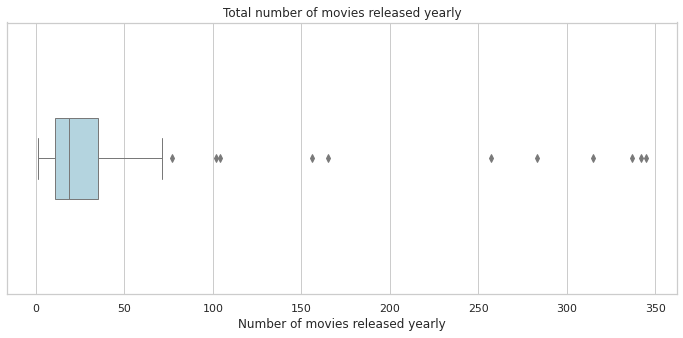

In [142]:
# Exercici:
# sns.set(style="whitegrid")
# ax = sns.boxplot(x = data['Quantity'], color='lightblue', fliersize=5, orient='v', linewidth=1, width=0.3)

plt.figure(figsize=(12,5))

sns.set(style="whitegrid")
ax = sns.boxplot(x = moviesByYear['Total'], color='lightblue', fliersize=5, orient='v', linewidth=1, width=0.3)
plt.title('Total number of movies released yearly');
plt.xlabel('Number of movies released yearly');

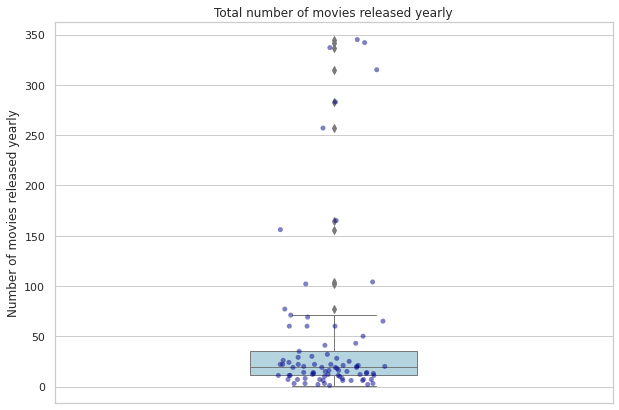

In [143]:
# Exercici:
# ax = sns.boxplot(y="Quantity", data=data,  color='lightblue', fliersize=5,  orient='v', linewidth=1 , width=0.3)
# ax = sns.stripplot(y=data["Quantity"], orient='v', color='darkblue', alpha= 0.5)

plt.figure(figsize=(10,7))

ax = sns.boxplot(y="Total", data=moviesByYear,  color='lightblue', fliersize=5,  orient='v', linewidth=1 , width=0.3)
ax = sns.stripplot(y=moviesByYear["Total"], orient='v', color='darkblue', alpha= 0.5)
plt.title('Total number of movies released yearly');
plt.ylabel('Number of movies released yearly');


In [144]:
moviesByYear.dtypes


Year                    int64
Decade               category
Total                   int64
Genre_Adventure         int64
Genre_Animation         int64
Genre_Children          int64
Genre_Comedy            int64
Genre_Crime             int64
Genre_Documentary       int64
Genre_Drama             int64
Genre_Fantasy           int64
Genre_Film-Noir         int64
Genre_Horror            int64
Genre_Musical           int64
Genre_Mystery           int64
Genre_Romance           int64
Genre_Sci-Fi            int64
Genre_Thriller          int64
Genre_War               int64
Genre_Western           int64
dtype: object

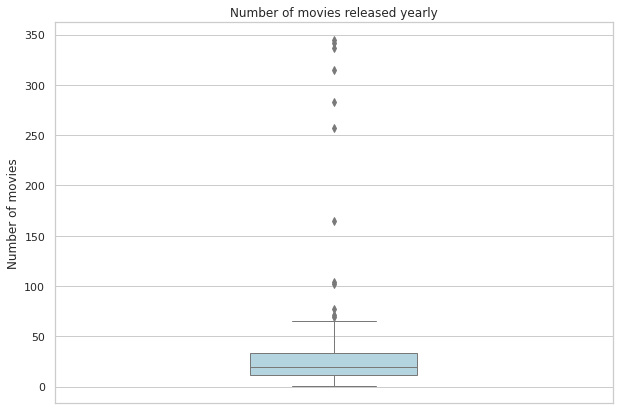

In [145]:
# Exercici:
# sns.boxplot(y="tip_pct", data=tips[tips.tip < 10],  color='lightblue', fliersize=5,  orient='v', linewidth=1 , width=0.3);

plt.figure(figsize=(10,7))

filter = (moviesByYear.Decade >= '1920s') & \
         (moviesByYear.Decade <= '1990s')

foo = moviesByYear[filter].copy()
foo['Decade'] = foo['Decade'].cat.remove_unused_categories() # Bug de seaborn, per evitar que pinti categories no utilizades les eliminem

sns.boxplot(y="Total", data=foo,  color='lightblue', fliersize=5,  orient='v', linewidth=1 , width=0.3);

plt.title('Number of movies released yearly');
plt.ylabel('Number of movies');


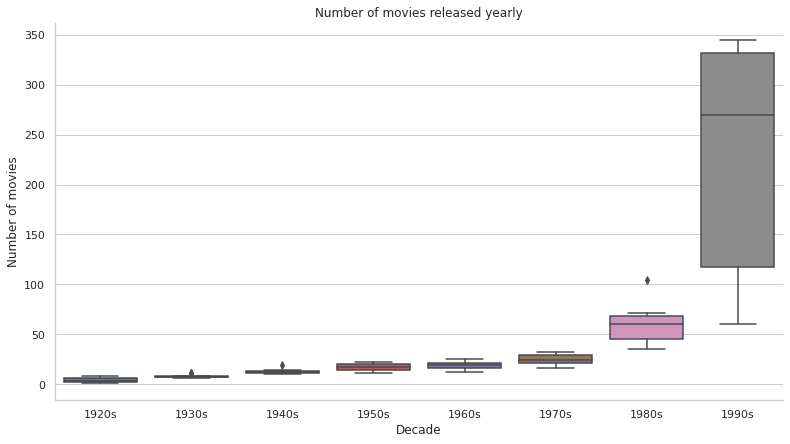

In [146]:
# Exercici:
# añadimos variable categorica 'day' en x:
# ax = sns.catplot(x='day', y='tip_pct', kind='box',
#                  data=tips[tips.tip_pct < 245]);

# añadimos variable categorica 'Decade' en x:

ax = sns.catplot(x='Decade', y='Total', kind='box', data=foo);
ax.fig.set_figwidth(12)
ax.fig.set_figheight(6)

plt.title('Number of movies released yearly');
plt.ylabel('Number of movies');

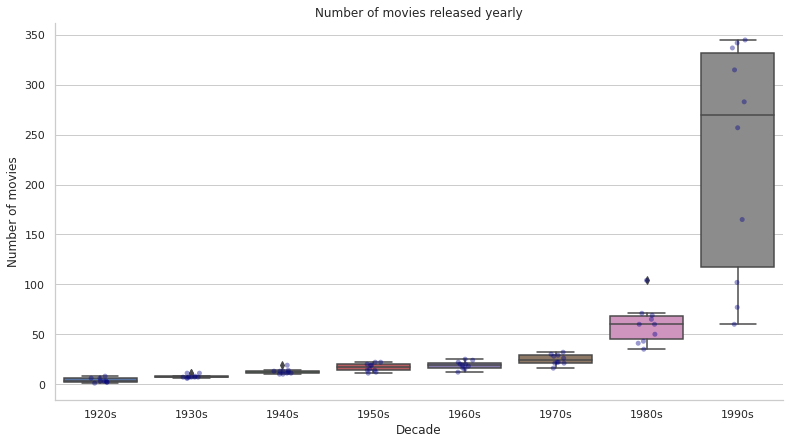

In [147]:
# Exercici:
# añadimos variable categorica 'day' en x:
# ax = sns.catplot(x='day', y='tip_pct', kind='box',
#                  data=tips[tips.tip_pct < 245]);
# ax = sns.stripplot(x='day', y='tip_pct', data=tips[tips.tip_pct < 245], orient='v', color='darkblue', alpha= 0.4);

ax = sns.catplot(x='Decade', y='Total', kind='box', data=foo);
ax.fig.set_figwidth(12)
ax.fig.set_figheight(6)

ax = sns.stripplot(x='Decade', y='Total', data=foo, orient='v', color='darkblue', alpha= 0.4);

plt.title('Number of movies released yearly');
plt.ylabel('Number of movies');

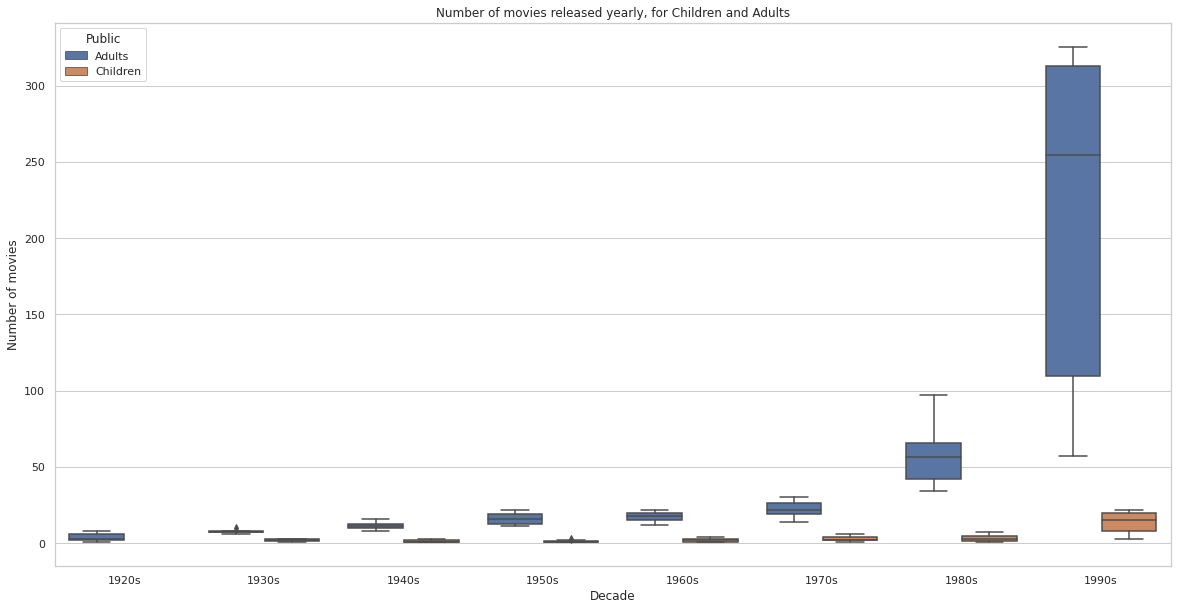

In [148]:
# Exercici:
# sns.boxplot(x='day', y='tip_pct', hue='time', 
#                data=tips[tips.tip_pct < 245]);

plt.figure(figsize=(20,10))

filter = (moviesByPublic.Decade >= '1920s') & \
         (moviesByPublic.Decade <= '1990s')

foo = moviesByPublic[filter].copy()
foo['Decade'] = foo['Decade'].cat.remove_unused_categories() # Bug de seaborn, per evitar que pinti categories no utilizades les eliminem

sns.boxplot(x='Decade', y='Total', hue='Public', data=foo);

plt.title('Number of movies released yearly, for Children and Adults');
plt.ylabel('Number of movies');

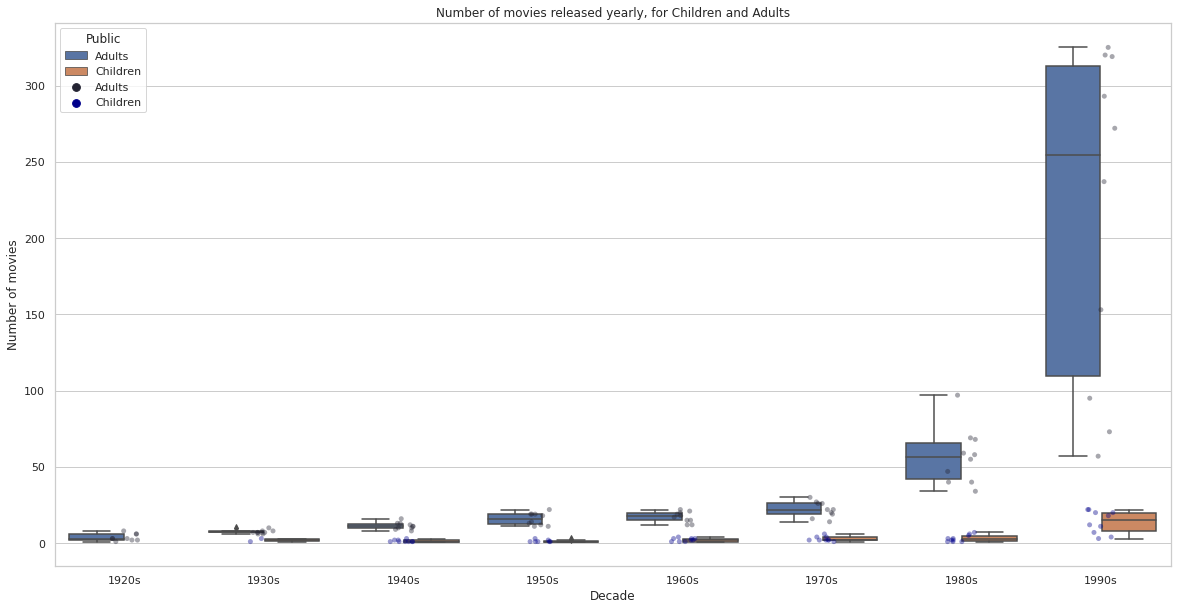

In [149]:
# Exercici:
# sns.boxplot(x='day', y='tip_pct', hue = 'time',
#                data=tips[tips.tip_pct < 245]);
# ax = sns.stripplot(x='day', y='tip_pct', hue='time', data=tips[tips.tip_pct < 245], orient='v', color='darkblue', alpha= 0.4);

plt.figure(figsize=(20,10))

sns.boxplot(x='Decade', y='Total', hue='Public', data=foo);
ax = sns.stripplot(x='Decade', y='Total', hue='Public', data=foo, orient='v', color='darkblue', alpha= 0.4);

plt.title('Number of movies released yearly, for Children and Adults');
plt.ylabel('Number of movies');

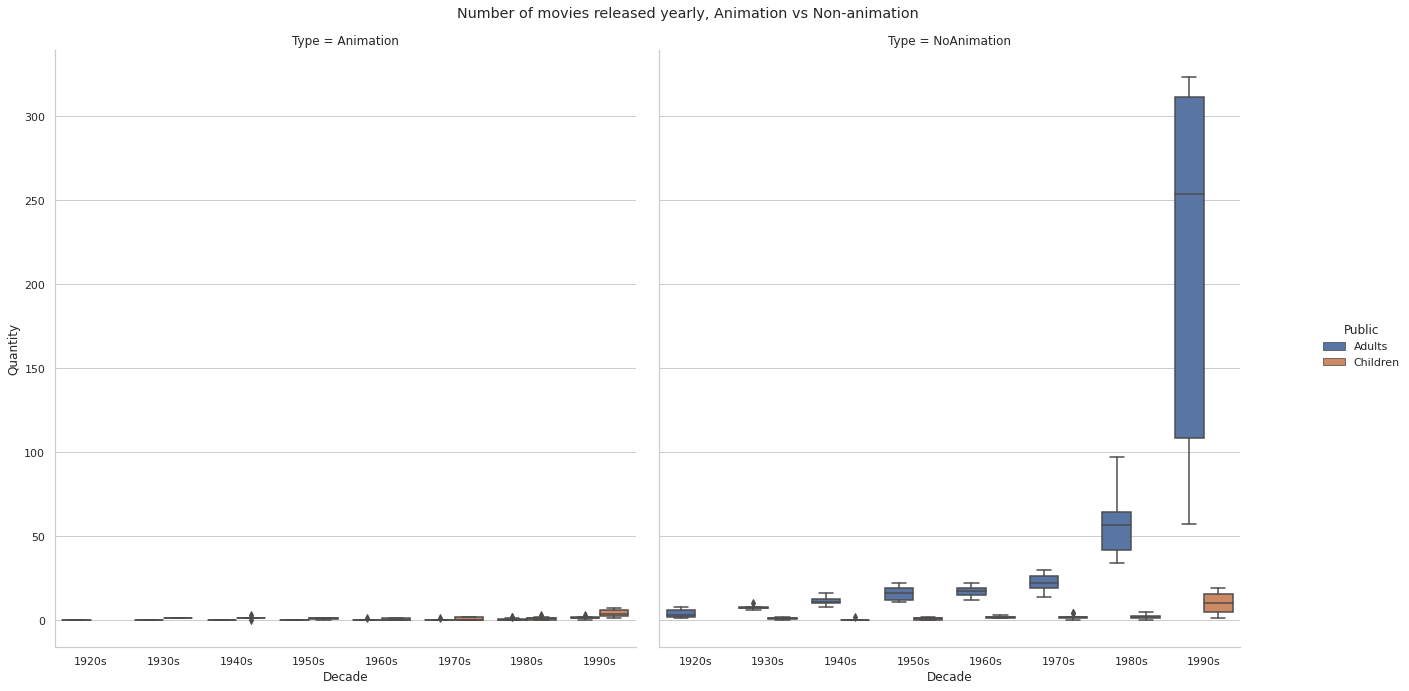

In [150]:
#Exercici:
# sns.catplot(x='day', y='tip_pct', hue='time', col='smoker',
#                kind='box', data=tips[tips.tip_pct < 245]);

filter = (moviesByPublic.Decade >= '1920s') & \
         (moviesByPublic.Decade <= '1990s')

foo = moviesByPublic[filter].copy()

foo = foo.melt(id_vars=['Year','Public','Decade'],
         value_vars=['AnimationQty','NoAnimationQty'],
         var_name='Type',
         value_name='Quantity')

foo['Type'] = foo['Type'].str.replace('Qty','')
foo['Decade'] = foo['Decade'].cat.remove_unused_categories() # Bug de seaborn, per evitar que pinti categories no utilizades les eliminem

g = sns.catplot(x='Decade', y='Quantity', hue='Public', col='Type',
               kind='box', data=foo);

g.fig.set_figwidth(20)
g.fig.set_figheight(10)

g.fig.suptitle('Number of movies released yearly, Animation vs Non-animation');


## Nivell 3

### Exercici 3

Mostreu-me la teva creativitat, Sorprèn-me amb el dataset "movies.dat" del exercici anterior.

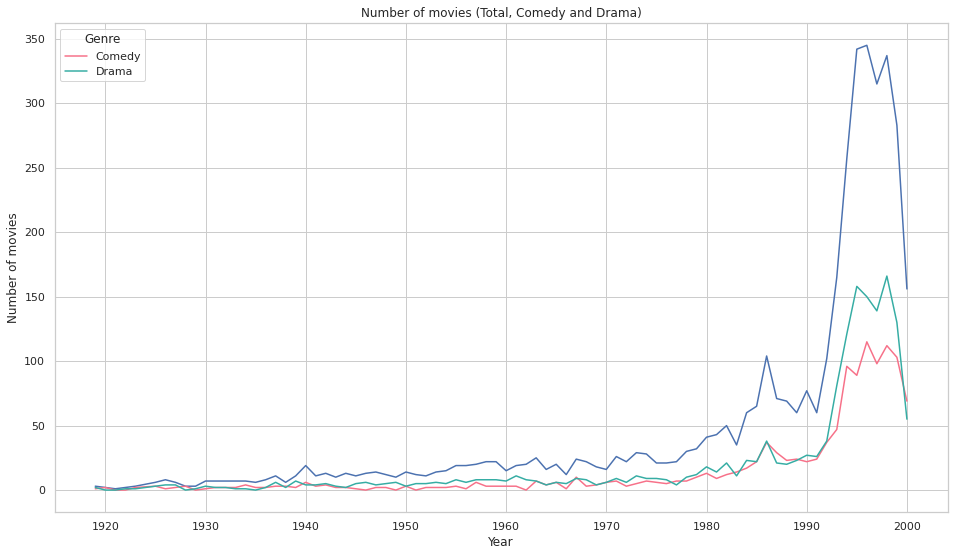

In [151]:
# Evolució del nombre de pel·lícules (total, comèdia i drama)

plt.figure(figsize=(16,9))

filter = (moviesByYearGenre.Genre == 'Comedy') | (moviesByYearGenre.Genre == 'Drama')
foo = moviesByYearGenre[filter].copy()
foo['Genre'] = foo['Genre'].cat.remove_unused_categories() # Bug de seaborn, per evitar que pinti categories no utilizades les eliminem

sns.lineplot(x='Year', y='Total', data=moviesByYear)
sns.lineplot(x='Year', y='Quantity', hue='Genre', data=foo, palette='husl')

plt.title('Number of movies (Total, Comedy and Drama)');
plt.ylabel('Number of movies');

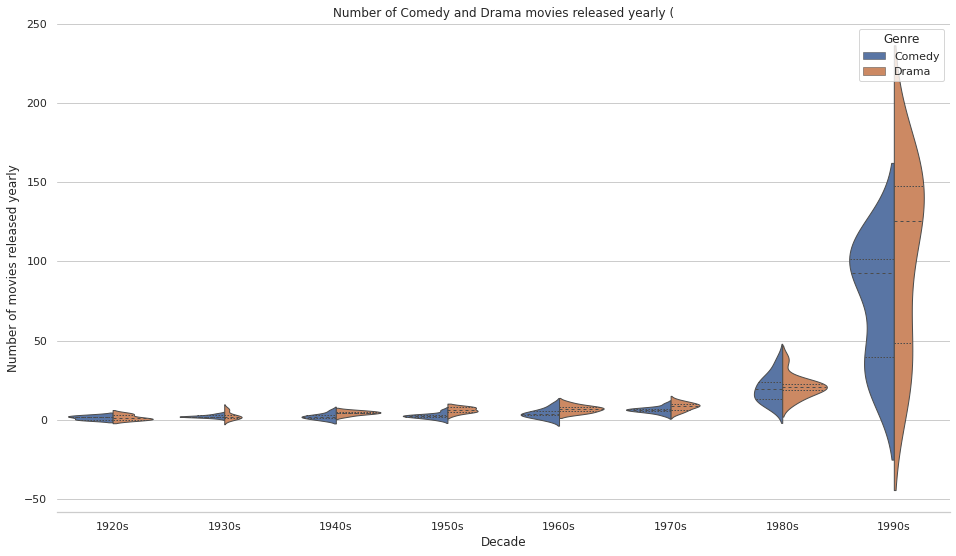

In [152]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(16,9))

filter_decade = (moviesByYearGenre.Decade >= '1920s') & (moviesByYearGenre.Decade <= '1990s')
filter_genre = (moviesByYearGenre.Genre == 'Comedy') | (moviesByYearGenre.Genre == 'Drama')

foo = moviesByYearGenre[filter_decade & filter_genre].copy()
foo['Genre'] = foo['Genre'].cat.remove_unused_categories() # Bug de seaborn, per evitar que pinti categories no utilizades les eliminem
foo['Decade'] = foo['Decade'].cat.remove_unused_categories() # Idem


# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=foo, x="Decade", y="Quantity", hue="Genre",
               split=True, inner="quart", linewidth=1)
sns.despine(left=True)

plt.title('Number of Comedy and Drama movies released yearly (');
plt.ylabel('Number of movies released yearly');


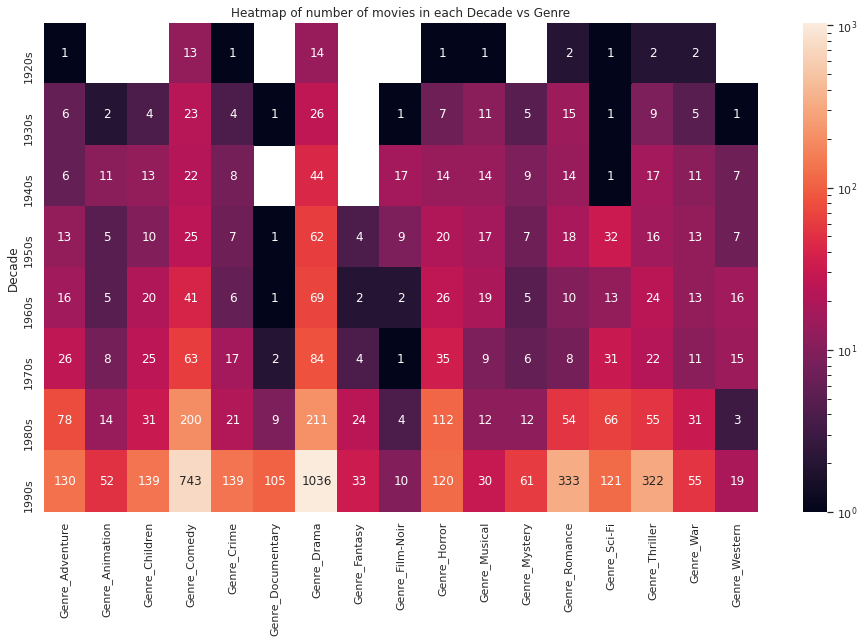

In [153]:
# Heatmap de Gènere vs Dècada
from matplotlib.colors import LogNorm

plt.figure(figsize=(16,9))

filter = (moviesByYear.Decade >= '1920s') & \
         (moviesByYear.Decade <= '1990s')
foo = moviesByYear[filter].groupby('Decade').sum().drop(['Year','Total'], axis=1)
foo.drop(['1910s','2000s'], inplace=True) # Eliminem 1910s i 2000s perquè no contenen tots els anys

sns.heatmap(foo,
            annot=True, 
            annot_kws={"size": 12}, 
            fmt='d',
            mask=(foo==0),
            norm=LogNorm())

plt.title('Heatmap of number of movies in each Decade vs Genre');
